<a href="https://colab.research.google.com/github/jialun1221/scRNA-seq/blob/main/LOgistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install scanpy
import numpy as np
import pandas as pd
import scanpy as sc
import sys
import random
from sklearn import preprocessing 
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import importlib
required_libraries = ['torch', 'torchvision', 'PIL', 'matplotlib', 
                      'numpy', 'pandas']
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        print("%s unavailable" % lib)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset

In [ ]:
#0. Model methods import
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# adata_m1 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/PC_all_genes_corrected.h5ad")
# adata_m2 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/pca_in_obsm_2500.h5ad")
# adata_m3 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/2500no_pca_new.h5ad")

# data_list = [adata_m1, adata_m2, adata_m3]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

adata_m1 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/MG_PC_all_genes.h5ad")
adata_m2 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/MG_PC_HVGs.h5ad")
adata_m3 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/MG_no_PC_HVGs.h5ad")

data_list = [adata_m1, adata_m2, adata_m3]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
adata_m1

AnnData object with n_obs × n_vars = 24082 × 29464
    obs: 'level_0', 'index', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cell_Subtype', 'Cell_Type', 'disease__ontology_label', 'organ__ontology_label', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
df_astro_lr = pd.DataFrame(columns = ['Seed', 'aLR m1 val', 'aLR m2 val', 'aLR m3 val','aLR m1 test', 'aLR m2 test', 'aLR m3 test'])

In [ ]:
dict_list_astro_lr_m1 = []
dict_list_astro_lr_m2 = []
dict_list_astro_lr_m3 = []

In [ ]:
#0. Define Logistic Regression Model 
def logisticRegressionTest():

  use_gpu = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_gpu else "cpu")

  model = LogisticRegression()
  model.fit(X_train, y_train)
  prediction_test = model.predict(X_test)

  #test accruacy 
  accuracy_test = metrics.accuracy_score(y_test, prediction_test)
  print("Test acc = ", metrics.accuracy_score(y_test, prediction_test))
  
  return prediction_test, accuracy_test

In [ ]:
#0. Define Logistic Regression Model for Validation
def logisticRegressionValidation():

  use_gpu = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_gpu else "cpu")

  model = LogisticRegression()
  model.fit(X_train, y_train)
  prediction_test_val = model.predict(X_val)

  #validation accuracy  
  accuracy_val = metrics.accuracy_score(y_val, prediction_test_val)
  print("Validation acc = ", metrics.accuracy_score(y_val, prediction_test_val))
  
  return prediction_test_val, accuracy_val

In [ ]:
def plot(y_test, prediction_test):
  confusion_matrix = metrics.confusion_matrix(y_test, prediction_test)
  # cmd = ConfusionMatrixDisplay(confusion_matrix, display_labels=['Healthy','PD'])
  cmd = ConfusionMatrixDisplay(confusion_matrix, display_labels=['Healthy','PD'])
  cmd.plot(cmap = 'YlGnBu', colorbar = False)

  plt.grid(False)

  fig = cmd.ax_.get_figure() 
  ax = fig.add_axes(['Healthy', 'PD'])

  ax.set_xticklabels(['Healthy', 'PD'])
  ax.set_ytickslabels(['Healthy', 'PD'])

  fig.set_figwidth(3)
  fig.set_figheight(3)
  plt.rcParams["figure.dpi"] = 300
  plt.rcParams["axes.labelcolor"] = 'black' #now useless

  plt.rc('font', size=16)
  # Set the axes title font size
  plt.rc('axes', titlesize=14)
  # Set the axes labels font size
  plt.rc('axes', labelsize=14)
  # Set the font size for x tick labels
  plt.rc('xtick', labelsize=14)
  # Set the font size for y tick labels
  plt.rc('ytick', labelsize=14)
  #plt.savefig(dpi = 300, fname = 'astro_LR.png')

mega-loop!

In [ ]:
import copy
i = 0 #method number

seed_list = []

for dataobj in data_list:
  print(i)
  print(dataobj)
  i = i + 1
  adata = dataobj

  #1. Pre-process data
  if 'level_0' not in adata.obs.columns:
    adata.obs = adata.obs.reset_index() #reset the index for X, so the column number starts from 0

  if 'X_pca' in adata.obsm:
    #if i == 0:
    # if isinstance(adata.obsm['X_pca'].X, np.ndarray):
    X = adata.obsm['X_pca'].X
    # elif isinstance(adata.obsm['X_pca'], np.ndarray):
    #   X = adata.obsm['X_pca']
    # else:
    #   # X = pd.DataFrame(adata.obsm['X_pca']) #DataFrame constructor not properly called!
    #   X = adata.obsm['X_pca']
  else:
    X = adata.X 
  
  y = adata.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

  #2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning. 
  #   Parameters for the highest accuracy can be used for test set.
  
  X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same

  #3. run 10 iterations
  for m in range (10):
    X_test = copy.deepcopy(X_test_global)
    y_test = copy.deepcopy(y_test_global)
    
    if len(seed_list) < 10:
      seed = random.randint(0, 9999)
      seed_list.append(seed)
      print("seed: ", seed)
      X_train, X_val, y_train, y_val = train_test_split(X_train_global, y_train_global, test_size=0.25, random_state= seed_list[m])
    else:
      print("seed = ", seed)
      print(seed_list[m])
      X_train, X_val, y_train, y_val = train_test_split(X_train_global, y_train_global, test_size=0.25, random_state= seed_list[m])

    prediction_val, accuracy_val = logisticRegressionValidation()
    prediction_test, accuracy_test = logisticRegressionTest()

    if i == 1: #write in method 1 section
      row_dict_m1 = {'Seed': seed_list[m], 'aLR m1 val': accuracy_val, 'aLR m1 test': accuracy_test}
      dict_list_astro_lr_m1.append(row_dict_m1)
    elif i == 2:
      row_dict_m2 = {'Seed': seed_list[m], 'aLR m2 val': accuracy_val, 'aLR m2 test': accuracy_test}
      dict_list_astro_lr_m2.append(row_dict_m2)
    elif i == 3:
      row_dict_m3 = {'Seed': seed_list[m], 'aLR m3 val': accuracy_val, 'aLR m3 test': accuracy_test}
      dict_list_astro_lr_m3.append(row_dict_m3)
      
print(dict_list_astro_lr_m1)
print(dict_list_astro_lr_m2)
print(dict_list_astro_lr_m3)


0
AnnData object with n_obs × n_vars = 24082 × 29464
    obs: 'index', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cell_Subtype', 'Cell_Type', 'disease__ontology_label', 'organ__ontology_label', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
seed:  4951
Validation acc =  0.9738426406477061
Test acc =  0.9765414158189745
seed:  2395
Validation acc =  0.9736350425576085
Test acc =  0.9757110234585842
seed:  3749
Validation acc =  0.978202200539755
Test acc =  0.9761262196387793
seed:  2986
Validation acc =  0.9757110234585842
Test acc =  0.9759186215486817
seed:  9700
Validation acc =  0.9763338177288768
Test acc =  0.9765414158189745
seed:  4657
Validation acc =  0.9771642100892671
Test acc =  0.97

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9543284201785344


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9501764583765829
seed =  3899
2395


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.957857587710193


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9541208220884367
seed =  3899
3749


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9580651858002907


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9537056259082416
seed =  3899
2986


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9530828316379489


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9553664106290222
seed =  3899
9700


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9547436163587295


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9522524392775586
seed =  3899
4657


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9561968029894125


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9561968029894125
seed =  3899
7258


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9572347934399004


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9545360182686319
seed =  3899
2700


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9553664106290222


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9522524392775586
seed =  3899
9275


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9566119991696076


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9576499896200955
seed =  3899
3899


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9555740087191198
Test acc =  0.9539132239983392
[{'Seed': 4951, 'aLR m1 val': 0.9738426406477061, 'aLR m1 test': 0.9765414158189745}, {'Seed': 2395, 'aLR m1 val': 0.9736350425576085, 'aLR m1 test': 0.9757110234585842}, {'Seed': 3749, 'aLR m1 val': 0.978202200539755, 'aLR m1 test': 0.9761262196387793}, {'Seed': 2986, 'aLR m1 val': 0.9757110234585842, 'aLR m1 test': 0.9759186215486817}, {'Seed': 9700, 'aLR m1 val': 0.9763338177288768, 'aLR m1 test': 0.9765414158189745}, {'Seed': 4657, 'aLR m1 val': 0.9771642100892671, 'aLR m1 test': 0.9773718081793648}, {'Seed': 7258, 'aLR m1 val': 0.978202200539755, 'aLR m1 test': 0.9771642100892671}, {'Seed': 2700, 'aLR m1 val': 0.9794477890803405, 'aLR m1 test': 0.9759186215486817}, {'Seed': 9275, 'aLR m1 val': 0.9746730330080964, 'aLR m1 test': 0.9765414158189745}, {'Seed': 3899, 'aLR m1 val': 0.9748806310981939, 'aLR m1 test': 0.9765414158189745}]
[{'Seed': 4951, 'aLR m2 val': 0.9634627361428275, 'aLR m2 test': 0.9597259705210712

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
df_astro_m1 = pd.DataFrame.from_dict(dict_list_astro_lr_m1)
df_astro_m2 = pd.DataFrame.from_dict(dict_list_astro_lr_m2)
df_astro_m3 = pd.DataFrame.from_dict(dict_list_astro_lr_m3)

In [ ]:
f = pd.concat([df_astro_m1, df_astro_m2,df_astro_m3])
f

,Seed,aLR m1 val,aLR m1 test,aLR m2 val,aLR m2 test,aLR m3 val,aLR m3 test
0,4951,0.973843,0.976541,NaN,NaN,NaN,NaN
1,2395,0.973635,0.975711,NaN,NaN,NaN,NaN
2,3749,0.978202,0.976126,NaN,NaN,NaN,NaN
3,2986,0.975711,0.975919,NaN,NaN,NaN,NaN
4,9700,0.976334,0.976541,NaN,NaN,NaN,NaN
5,4657,0.977164,0.977372,NaN,NaN,NaN,NaN
6,7258,0.978202,0.977164,NaN,NaN,NaN,NaN
7,2700,0.979448,0.975919,NaN,NaN,NaN,NaN
8,9275,0.974673,0.976541,NaN,NaN,NaN,NaN
9,3899,0.974881,0.976541,NaN,NaN,NaN,NaN


TypeError: ignored

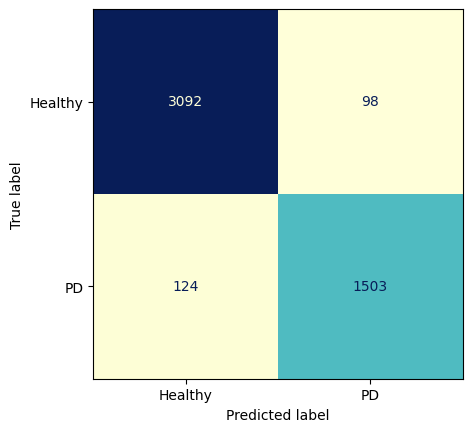

In [ ]:
plot(y_test, prediction_test)

###**Creating Plots**

In [ ]:
#4. Re-run Logistic Regression with the seed that generates the highest acc to draw plot
chosenseedm1=df_astro_m1['Seed'][df_astro_m1['aLR m1 test'].idxmax()]
if 'X_pca' in adata_m1.obsm:
  X = adata_m1.obsm['X_pca'].X
else:
  X = adata_m1.X 
    
y = adata_m1.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

#2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning. 
#   Parameters for the highest accuracy can be used for test set.
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state= chosenseedm1)

prediction_test, accuracy_test = logisticRegressionTest()

plot(y_test, prediction_test)

In [ ]:
# #there is error!!!
# def logisticRegression_final_evaluation(seed):
#   if 'X_pca' in adata_m1.obsm:
#     X = pd.DataFrame(adata_m1.obsm['X_pca'])
#   else:
#     X = adata_m1.X 
    
#   y = adata_m1.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

#   #2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning. 
#   #   Parameters for the highest accuracy can be used for test set.
  
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same
#   X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state= seed)

#   prediction_test, accuracy_test = logisticRegressionTest()
#   return prediction_test, accuracy_test

In [ ]:
#4. method 2
chosenseedm2=df_astro_m2['Seed'][df_astro_m2['aLR m2 test'].idxmax()]
print(chosenseedm2)
if 'X_pca' in adata_m2.obsm:
  X = adata_m2.obsm['X_pca'].X
else:
  X = adata_m2.X 
    
y = adata_m2.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

#2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning. 
#   Parameters for the highest accuracy can be used for test set.
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state= chosenseedm2)

prediction_test, accuracy_test = logisticRegressionTest()
prediction_test.astype('float64')
y_test.astype('float64')
plot(y_test, prediction_test)

In [ ]:
#4. method 3
chosenseedm3=df_astro_m3['Seed'][df_astro_m3['aLR m3 test'].idxmax()]
if 'X_pca' in adata_m3.obsm:
  X = pd.DataFrame(adata_m3.obsm['X_pca'])
else:
  X = adata_m3.X 
    
y = adata_m3.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

#2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning. 
#   Parameters for the highest accuracy can be used for test set.
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state= chosenseedm3)

prediction_test, accuracy_test = logisticRegressionTest()
plot(y_test, prediction_test)